In [1]:
import numpy as np
from numpy.linalg import inv,det
import matplotlib.pyplot as plt

# For GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# For polynominal Mean prediction
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Configuration, Data Info

In [2]:
# Data, output file address
data_address = "./data/"
output_address = "./output/"

# Data Configuration
data_length = 50

# Mean function Configuration
linear_horizon = 10 # linear regression indice 길이, t(end)로부터 얼마나 할지
poly_order = 3 # polynominal regression 차수

# GP Configuration - parameter
lengthscale = 1.0
sigma = 1.0

# GP Configuration - prediction
pred_length = 10

## Data Load

In [3]:
# Data load


import time
tic = time.time()

## Transform Data to Error-wise

In [4]:
# Generate temp data
t = np.linspace(start=0, stop=20, num = data_length+pred_length).reshape(-1,1)
X = np.squeeze(t*np.sin(t))

In [5]:
# Linear Regression
def linear_mean_func(t, x, horizon=10):
    # Set numpy indices for linear regression
    indices = np.arange(start=t.size-10, stop=t.size)
    
    # Linear regression
    model = LinearRegression()
    model.fit(t[indices], x[indices])
    
    # Generate mean in regard to observation timestep 
    mean_pred = model.predict(t[indices])
    
    # Plot
    if(show_inner_plt==True):
        plt.subplot(2,1,1)
        plt.plot(t, x, label='data')
        plt.scatter(t, x, label='Observation')
        plt.scatter(t[indices], mean_pred, label='linear regression')
        plt.xlabel('time (s)')

    return mean_pred

# Polynominal Regression
def polyn_mean_func(t, x, order=3):
    # generate Polynominal
    poly = PolynomialFeatures(degree=order, include_bias=True)
    t_poly = poly.fit_transform(t)
    
    # Fit
    model = LinearRegression()
    model.fit(t_poly, x)
    
    # Generate mean in regard to observation timestep 
    mean_pred = model.predict(t_poly)
    
    # Plot
    if(show_inner_plt==True):
        plt.subplot(2,1,1)
        plt.plot(t, x, 'k', label='data')
        plt.scatter(t, x, c='red', label='Observation')
        plt.scatter(t, mean_pred, label='polynominal regression')
        plt.xlabel('time (s)')
        plt.legend()
    
    return mean_pred

# Unicycle (TBD)
def Unicycle_mean_func(t,x,y):
    mean_pred = 0
    return mean_pred

In [6]:
show_inner_plt = False

# Transform Data
# X_mean = linear_mean_func(t, x, horizon=linear_horizon)
X_mean = polyn_mean_func(t, X, order=8)
X_err_train = X - X_mean

# Show X_error
if(show_inner_plt==True):
    plt.subplot(2,1,2)
    plt.plot(t, X_err_train, label='X_error')
    plt.xlabel('time (s)')

    plt.show()

## GPR

In [7]:
noise_std = 1.25

# GP & Kernel Define
kernel = 1 * RBF(
    length_scale=1.0,
    length_scale_bounds=(1e-1, 1e+1)
)
gaussian_process = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_std**2,
    n_restarts_optimizer=9
)

# Fit (Parameter Learning)
gaussian_process.fit(t[:data_length], X_err_train[:data_length])

# Show Trained Kernel
# gaussian_process.kernel_

# GP Regression
mean_prediction, std_prediction = gaussian_process.predict(t, return_std=True)

In [8]:
a = [1,2,3,4,5]

## Back Transfrom from Error-wise

In [9]:
mean_prediction = mean_prediction + X_mean

toc = time.time()
print('Elapsed: %.2f (sec)' % (toc-tic))

Elapsed: 0.14 (sec)


## Plot

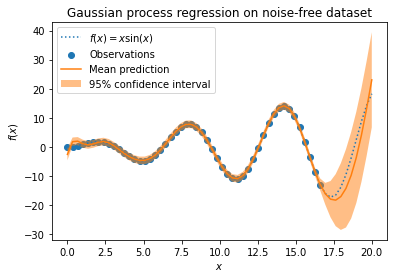

In [10]:
## Plot Result
plt.plot(t, X, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(t[:data_length], X[:data_length], label="Observations")
plt.plot(t, mean_prediction, label="Mean prediction")

# plot Variance 
plt.fill_between(
    t.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)

# plot info
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")